<a href="https://colab.research.google.com/github/mehdi-or/203B/blob/master/Metadata_making_fMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import csv

mounting the Gdrive

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This function is written to load the data

In [18]:
source = '/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/fMRI/s'
def load_data(subject, dim=20):
    accuracy = pd.read_csv(source + str(subject)+ '/accuVsdim.csv', header=None ).values
    X_test = pd.read_csv(source +  str(subject)+ '/X_test_'+str(dim)+'.csv', header=None ).values
    decoded_VT = pd.read_csv(source + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values
    BN = pd.read_csv(source + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values

    #accuracy = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/accuVsdim.csv', header=None ).values
    #X_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/X_test_'+str(dim)+'.csv', header=None ).values
    #decoded_VT = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values
    #BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/BN_dim_'+str(dim)+'.csv', header=None ).values

    return(accuracy, X_test, decoded_VT, BN)

This function is written to find the mean correllation of the digonal of 40x40 classes similarity matrix

In [19]:
def class_diagonal(categ_aranged, corr, num_trials, y_test):

  diag_index = range(num_trials) # to find the index of the diagonals of the test-set matrix
  corr_zero = np.copy(corr)
  corr_zero[diag_index, diag_index]=0 # to remove the auto-correlaiton of the trials
  corr_df = pd.DataFrame(corr_zero) # turning it to DataFrame to make my life easier by ALOT
  corr_df.columns=y_test # to name the columns of the correlation
  corr_df.index = y_test # to name the rows of the correlation
  unique_class = np.unique(y_test) # to find what uniqw classes we have in the test-set
  class_matrix_corr = np.zeros((len(unique_class),len(unique_class))) # this is the correlation of the mean values of the classes
  #trial_matrix_corr = np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories
  #trial_matrix_corr =np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories

  for i, row in enumerate(categ_aranged):
    for j, column in enumerate(categ_aranged):
      #trial_matrix_corr [row, column]=  corr_df.loc[row][column]
      if i==j:
        n_examples = np.sqrt(corr_df.loc[row][column].size) # this is for the case of autocorrelation that we have already put zeros for them so it is fair to not consider them while getting the mean
        #print( row + ' = ' + str(n_examples) + ' trials')
        class_matrix_corr [i,j] = corr_df.loc[row][column].sum().sum()/(n_examples**2 - n_examples)
      else:
        class_matrix_corr [i,j]= corr_df.loc[row][column].mean().mean()
  return(class_matrix_corr)

To calulate pairwise Eculidean distance

In [20]:
def EDM(A,B):
  p1=np.sum(A**2, axis=1)[:, np.newaxis]
  p2=np.sum(B**2, axis=1)
  p3=-2*np.dot(A,B.T)
  return np.round(np.sqrt(p1+p2+p3), 2)

This is to write the

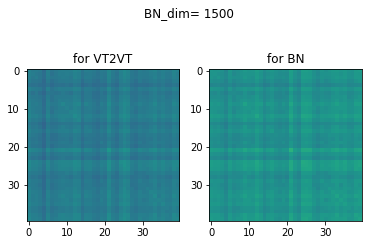

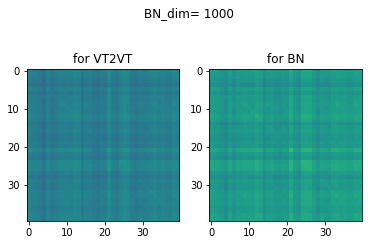

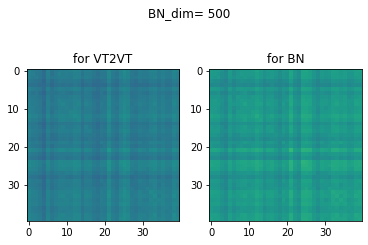

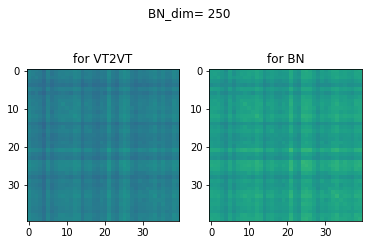

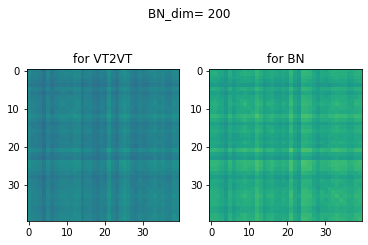

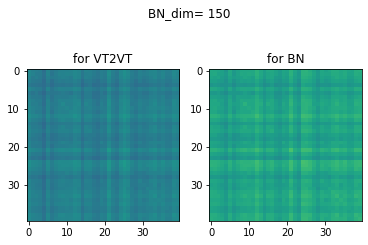

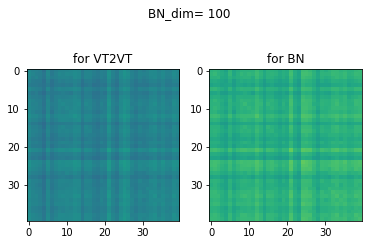

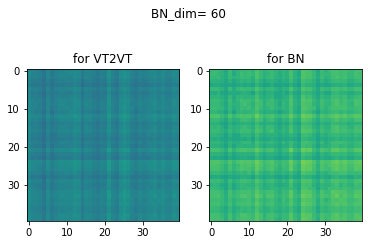

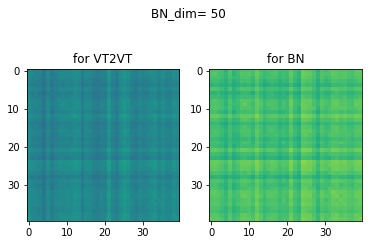

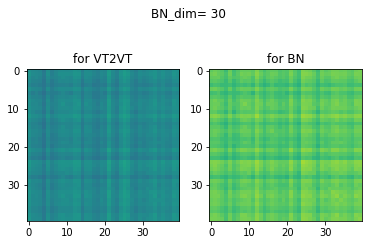

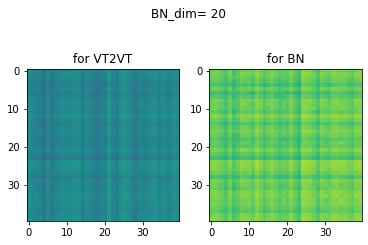

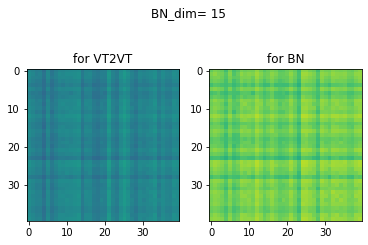

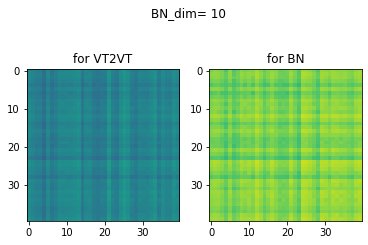

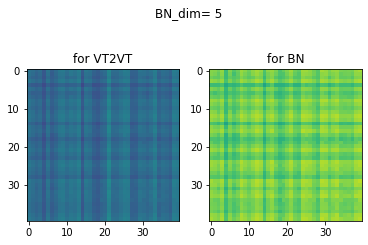

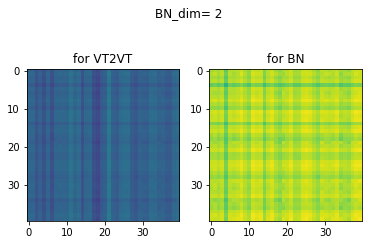

In [26]:
networks = ['AE_plain', 'AE_plus'] # which network arichitecture we want to use
subjects = range(37,39) # subjects we are looking at
label = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv').values # reading the labels based on the order showing to the subjects
categ_aranged = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).iloc[:,1].values # these are 40 classes that are arranged based on categories
#the map for all subject is the same so any one would be fine for it. I am using subjects[0]
#map = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subjects[0])+ '/map2.csv', header=None ).values.astype(int) 
map = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subjects[0])+ '/map2.csv', header=None ).values.astype(int) 
y_test = label[map] # finding which exaplars were used in the test-set while training the AE/AE+
y_test= y_test.reshape(y_test.shape[0])
num_trials = map.shape[0]

accuracy_dictionary ={} #creating bunch of dictionaries to store data
corr_dictionary = {}
corr_class_dictionary = {}
corr_BN_class_dictionary = {}
#corr_BN_class_dictionary_new = {}
dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2] # mdimension of the BottleNeck
for subject in subjects:
  [accuracy,_,_,_] = load_data(subject)
  corr_list = [] # a list of correlaion of the decoded examplars (1x15)
  class_corr_list = [] # a list of correlation of the categoreies for decoded examplars (1x15)
  class_corr_BN_list = [] # a list of correlation of the categoreies for BN(1x15)
  categ = np.unique(y_test)
  num_trials = len(y_test)
  for dim in dims:
      [accuracy, X_test, decoded_VT, BN] = load_data(subject, dim)
      corr0 = np.corrcoef(X_test, decoded_VT)
      indx = int(corr0.shape[0]/2) 
      corr=corr0[indx:,:indx] # we want only the part of the correlation matrix between the X_test and decoded_img
      corr_BN = np.corrcoef(BN)

      diagonal_corr_mean= np.diagonal(corr).mean()
      corr_list.append(diagonal_corr_mean) # listing the mean of the diagonal of correlation for each dimension
      
      class_corr = class_diagonal(categ, corr, num_trials, y_test)
      class_corr_diagonal_mean = np.diagonal(class_corr).mean()
      #to calculate the off_diag_corr for reconstuct"
      off_diag_indx0 = np.where(~np.eye(class_corr.shape[0],dtype=bool))
      class_corr_off_diag_mean = class_corr[off_diag_indx0].mean()
      class_corr_relative = class_corr_diagonal_mean - class_corr_off_diag_mean
      class_corr_list.append(class_corr_relative) # the mean correlation of the the "digaonal - off_diagonal" based on the categories (not examplars) for BN

      
      class_corr_BN = class_diagonal(categ, corr_BN, num_trials, y_test)
      class_corr_BN_diagonal_mean = np.diagonal(class_corr_BN).mean()
      #to calculate the off_diag_corr_BN"
      off_diag_indx = np.where(~np.eye(class_corr_BN.shape[0],dtype=bool))
      class_corr_BN_off_diag_mean = class_corr_BN[off_diag_indx].mean()
      class_corr_BN_relative = class_corr_BN_diagonal_mean - class_corr_BN_off_diag_mean
      class_corr_BN_list.append(class_corr_BN_relative) # the mean correlation of the the "digaonal - off_diagonal" based on the categories (not examplars) for BN


      if subject==subjects[-1]:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(class_corr, vmin = 0, vmax =0.9)
        ax2.imshow(class_corr_BN, vmin = 0, vmax =0.9)
        fig.suptitle('BN_dim= '+ str(dim))
        ax1.set_title('for VT2VT')
        ax2.set_title('for BN')

  corr_dictionary['subject%s' %subject] = corr_list
  corr_class_dictionary['subject%s' %subject] = class_corr_list

  accuracy_dictionary['subject%s' %subject] = accuracy

  corr_BN_class_dictionary['subject%s' %subject] = class_corr_BN_list


Wrtting the dictionary files into a csv

(0.0, 1.2)

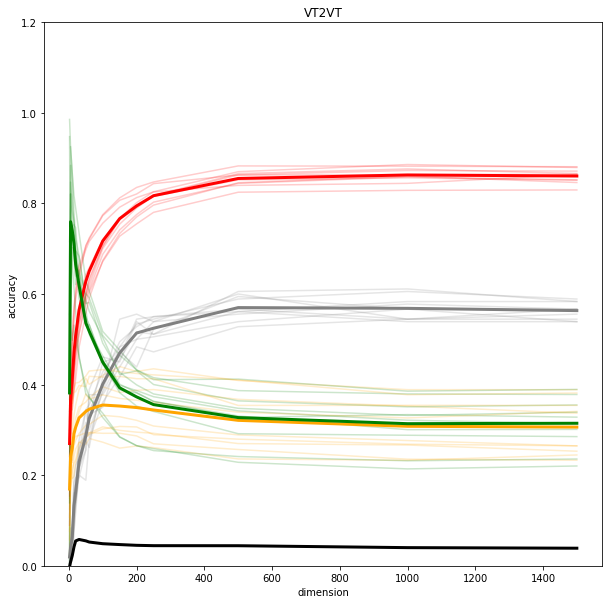

In [ ]:
index_name = ['1500', '1000', '500', '250', '200', '150', '100', '60', '50', '30', '20', '15', '10', '5', '2']
col_name =['dimension','accuracy', 'corr','corr_class', 'corr_BN_class', 'corr_class_norm','corr_BN_class_norm']
dim1= accuracy.shape[0] # number of the diffrent dimesion of BN (here is 15)
dim2= len(subjects) # number of the subjects (here is 10)
accuracy_all = np.zeros((dim1, dim2)) #storing all accuracy comprasing of (dim1*dim2 elements)
corr_all = np.zeros((dim1, dim2))
corr_class_all = np.zeros((dim1, dim2))
corr_BN_class_all = np.zeros((dim1, dim2))

plt.figure(figsize=(10,10))
AE_plain_fmri = np.zeros((dim1, 5, dim2))
for i, subject in enumerate(subjects):
    accuracy = accuracy_dictionary['subject'+str(subject)]

    corr_list = corr_dictionary['subject'+str(subject)]
    corr_class_list = corr_class_dictionary['subject'+str(subject)]
    corr_BN_class_list = corr_BN_class_dictionary['subject'+str(subject)]

    accuracy_all[:,i] = accuracy[:,1]
    corr_all[:,i] = corr_list
    corr_class_all[:,i] = corr_class_list
    corr_BN_class_all[:,i] = corr_BN_class_list

    normalized = (corr_class_list-np.min(corr_class_list))/(np.max(corr_class_list)-np.min(corr_class_list)) # to normalize the corr of reconstructed
    normalized_BN = (corr_BN_class_list-np.min(corr_BN_class_list))/(np.max(corr_BN_class_list)-np.min(corr_BN_class_list)) # to normalize the corr of BN

    plt.plot(accuracy[:,0], accuracy[:,1], alpha=0.2, c= 'grey')
    plt.plot(accuracy[:,0], corr_list, alpha=0.2, c='red')
    plt.plot(accuracy[:,0], corr_class_list, alpha=0.2, c='orange')
    plt.plot(accuracy[:,0], corr_BN_class_list, alpha=0.2, c='green')
    AE_plain_fmri[:,:,i] = np.asarray([accuracy[:,0], accuracy[:,1], corr_list, corr_class_list, corr_BN_class_list, normalized, normalized_BN]).T
    #DataFrame(AE_plain_fmri[:,:,i],index=index_name, columns=col_name).to_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/plus_meta_data/s_'+str(subject)+'_metadata.csv')

    #plt.xlim([0,30])


accuracy1 = np.asarray(accuracy)
mean_accuracy = np.mean(accuracy_all, axis=1)
mean_corr = np.mean(corr_all, axis=1)
mean_corr_class = np.mean(corr_class_all, axis=1)
mean_corr_BN = np.mean(corr_BN_all, axis=1)
mean_corr_BN_class = np.mean(corr_BN_class_all, axis=1)


plt.plot(accuracy[:,0],mean_accuracy, linewidth=3, c='grey')
plt.plot(accuracy[:,0],mean_corr, linewidth=3, c = 'red')
plt.plot(accuracy[:,0],mean_corr_class, linewidth=3, c = 'orange')
plt.plot(accuracy[:,0],mean_corr_BN_class, linewidth=3, c = 'green')
plt.title('VT2VT')
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.ylim([0,1.2])
#plt.xlim([0,200])


In [ ]:
normalized = (mean_corr_BN_class_new-np.min(mean_corr_BN_class_new))/(np.max(mean_corr_BN_class_new)-np.min(mean_corr_BN_class_new))

fig,ax = plt.subplots()
ax.plot(accuracy[:,0],mean_accuracy, linewidth=3, c='grey')
ax.plot(accuracy[:,0],mean_corr, linewidth=3, c = 'red')
ax.plot(accuracy[:,0],mean_corr_class, linewidth=3, c = 'orange')
ax.plot(accuracy[:,0],mean_corr_BN_class, linewidth=3, c = 'green')

ax.set_title('VT2VT')
ax.set_xlabel('dimension')
ax.set_ylabel('accuracy')
ax2 = ax.twinx()
ax2.set_ylabel('corr_ratio', c='black')
ax2.plot(accuracy[:,0],normalized, linewidth=3, c = 'black')
plt.ylim([0,1])
#plt.xlim([0,200])

(0.0, 250.0)

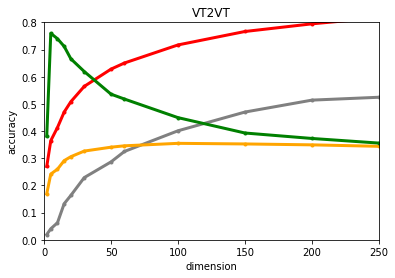

In [ ]:
plt.plot(accuracy[:,0],mean_accuracy,'.-', linewidth=3, c='grey')
plt.plot(accuracy[:,0],mean_corr, '.-', linewidth=3, c = 'red')
plt.plot(accuracy[:,0],mean_corr_class, '.-', linewidth=3, c = 'orange')
plt.plot(accuracy[:,0],mean_corr_BN_class, '.-', linewidth=3, c = 'green')
plt.title('VT2VT')
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.ylim([0,0.8])
plt.xlim([0,250])